In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use({'figure.facecolor':'white'})
import matplotlib as mpl
from matplotlib.patches import Rectangle
from matplotlib import rc
from matplotlib import cm, ticker
mpl.rcParams['font.size'] = 16
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

#mpl.rcParams['font.family'] = ['times new roman'] # default is sans-serif
#rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=False)
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath,bm}'] #for \text command

import scipy.stats as ss
from tqdm import tqdm
from datetime import datetime
now = datetime.now()
date = now.strftime("%d_%m_%Y_%H:%M")
import torch as th
import seaborn as sns
from mpl_toolkits import mplot3d
import fenics_concrete
import yaml
# local imports
from usecases.demonstrator.Calibration.utils.sampler import random_walk_metropolis

# Initialize random number generator
RANDOM_SEED = 420
rng = np.random.default_rng(RANDOM_SEED)
%load_ext autoreload
%autoreload 2
seed = 420

/tmp/ipykernel_31762/2273200294.py:16: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath,bm}'] #for \text command


## Loading exp data

In [2]:
data_file = '../artificial_hydration_data/artificial_hydration_data.yaml'
#Example 1:
# read file and access artificial data:
with open(data_file) as file:
    hydration_data = yaml.safe_load(file)

# data is given in dictionary
# data[mix ratio: 0/.2/0.5/.8/1][temperature: 20/40/60][time/heat]
# it is assumed that this is hydration data for two distinct mixes
# mix 1: mix ration = 0 and mix 2: mix ratio = 1
# there are 3 intermediate mixes with 20/80, 50/50 and 80/20 ratio between mix 1 and 2
# for each of the 5 mixes there are 3 temperature measurements, each at 20, 40 and 60 degree
# for each temperature there is a list with the time and the heat values

# loop over all data, print lists
for mix_r in hydration_data:
    for temp in hydration_data[mix_r]:
        print(mix_r,temp,'time:',hydration_data[mix_r][temp]['time'])
        print(mix_r,temp,'heat:',hydration_data[mix_r][temp]['heat'])

0 20 time: [1523.8095238095204, 4952.3809523809505, 8205.489092188598, 11972.78911564625, 15283.446712018129, 18137.461881304233, 20828.390469488288, 22932.2073657049, 24987.098287590896, 27041.989209476887, 29096.880131362883, 31037.61044647744, 33157.73600080426, 35310.47887135149, 37561.07369055996, 39371.33474079287, 41426.225662678866, 43481.11658456486, 45584.93348078148, 48275.86206896551, 51129.87723825162, 54326.374227852066, 57454.37485338963, 61290.17124091015, 65244.279529993815, 68980.44484251381, 72934.55313159747, 77044.33497536946, 81122.98210820378, 85073.63098496104, 87661.27140511374, 90666.66666666667, 95619.04761904762, 102045.50785831573, 108190.4761904762, 115428.57142857143, 122666.66666666664, 127389.16256157636, 132952.38095238095, 141088.43537414967, 147428.57142857145, 153904.7619047619, 158555.00821018062, 164952.38095238095, 171047.61904761902, 175336.61740558292, 184380.95238095243, 189714.2857142857, 193523.80952380953, 198857.14285714287, 206476.1904761

In [3]:
hydration_data[0][20]['heat']

[1.2106537530266905,
 2.663438256658594,
 4.427533725354579,
 10.957907417788874,
 18.417045368702702,
 27.087930438101637,
 35.90393492288797,
 43.91452665227405,
 51.79451090781146,
 60.392836269516636,
 68.66464294660005,
 76.06573313135897,
 84.97502866889431,
 93.37122341630987,
 102.42045553296884,
 110.67671370126078,
 118.4043225706414,
 126.37137847541123,
 134.43794483644672,
 142.8388041364998,
 151.7817881097501,
 160.34383361760837,
 168.79703956392615,
 176.8511671179284,
 184.91518917752535,
 192.4548024406086,
 199.16327723374565,
 205.69365092618,
 212.10529055147913,
 218.10136094180515,
 220.7135104187789,
 226.39225181598067,
 232.9297820823245,
 240.95766886532525,
 245.27845036319616,
 253.26876513317194,
 259.80629539951576,
 264.4670141580888,
 269.24939467312345,
 276.2216868044705,
 280.1452784503632,
 283.77723970944317,
 287.97635945085227,
 289.588377723971,
 291.7675544794189,
 295.15977051253003,
 298.30508474576277,
 301.9370460048426,
 302.6634382566586

In [4]:
class Prior_(object):
    def __init__(self,x):
        self.x = x
        #self.sigma = sigma
        self.cov = None
    def _b_mean(self,x,phi):
        assert phi.ndim == 2
        b_vec = th.matmul(phi[:,:-1],x) + phi[:,-1]
        return b_vec
    def logeval(self,b,phi :list):
        phi_mean = phi[0]
        phi_sd_diag = phi[1]
        phi_ = th.tensor(phi_mean,requires_grad=True)
        mean = self._b_mean(th.from_numpy(self.x),phi_)
        assert mean.shape[0] == phi_sd_diag.shape[0]
        phi_sd_diag_ = th.tensor(phi_sd_diag,requires_grad=True) # diagonal entries of cov
        self.cov = th.diag(phi_sd_diag_)
        dist = th.distributions.MultivariateNormal(mean,self.cov)
        val = dist.log_prob(th.from_numpy(b))
        val.backward()
        grad_phi = phi_.grad
        grad_sigma = phi_sd_diag_.grad
        return val.detach().numpy(), grad_phi.detach().numpy() ,grad_sigma.detach().numpy() # negative as later grad ascent needs to performed to find arg max logp(D|phi)


In [5]:
phi_test = np.random.rand(4,2)
x_test = np.array([0.])
pr = Prior_(x =x_test)

In [6]:
b_test = pr._b_mean(th.from_numpy(x_test),th.from_numpy(phi_test))
phi_sd = np.ones(4)
phi = [phi_test, phi_sd]
pr.logeval(b_test.numpy(),phi)

/home/atul_0711/Documents/PhD_Tasks/LeBeDigital/Codes/ModelCalibration/ModelCalibration/conda-env/lib/python3.9/site-packages/torch/autograd/__init__.py:173: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484775609/work/c10/cuda/CUDAFunctions.cpp:109.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


(array(-3.67575413),
 array([[0., 0.],
        [0., 0.],
        [0., 0.],
        [0., 0.]]),
 array([-0.5, -0.5, -0.5, -0.5]))

In [7]:
class ForwardBase:
    def __init__(self, inp_obs, inp_unobs):
        self.inp_obs = inp_obs
        self.inp_unobs =inp_unobs
    def forward(self):
        raise NotImplementedError ("The forward method needs to be overloaded or defined for a specific solver")

In [8]:
def forward_model(inp_latents: list, inp_obs: dict) -> list:
    parameter = fenics_concrete.Parameters()  # using the current default values

    # -- latents -----
    # parameter['B1'] = 2.916E-4  # in 1/s (le 0, < 0.1)
    # parameter['B2'] = 0.0024229  # - (le 0, smaller 1)
    # parameter['eta'] = 5.554  # something about diffusion (should be larger 0)
    # parameter['T_ref'] = 25  # reference temperature in degree celsius
    # parameter['Q_pot'] = 500e3 # potential heat per weight of binder in J/kg

    parameter['B1'] = inp_latents[0]  # in 1/s (le 0, < 0.1)
    parameter['B2'] = inp_latents[1] # - (le 0, smaller 1)
    parameter['eta'] = inp_latents[2]  # something about diffusion (should be larger 0)
    parameter['Q_pot'] = inp_latents[3] # potential heat per weight of binder in J/kg

    # -- observed inputs
    parameter['igc'] = 8.3145  # ideal gas constant in [J/K/mol], CONSTANT!!!
    parameter['zero_C'] = 273.15  # in Kelvin, CONSTANT!!!
    parameter['E_act'] = 47002  # activation energy in Jmol^-1 (no relevant limits) (Depends only on simulated temp, if that is not change no need to infer E_act)
    parameter['alpha_max'] = 0.875  # also possible to approximate based on equation with w/c (larger 0 and max 1)
    parameter['T_ref'] = 25  # reference temperature in degree celsius

    # this is the minimal time step used in the simulation
    # using a larger value will increase the speed but decrease the accuracy
    dt = 300 # value in seconds

    # this is the simulated temperature, needs to be adjusted depending on the temperature of the experimental data
    T = inp_obs['T_rxn'] # can be 20,40,60 as pert the exp values
    # this is the list of measured time data as given by the experiments
    #time_list = [0,5000,10000,20000,100000]
    time_list = inp_obs['time_list']

    # initiate material problem, for this the "fenics_concrete" conda package needs to be installed
    # use: 'mamba install -c etamsen fenics_concrete"
    problem = fenics_concrete.ConcreteThermoMechanical()

    # get the hydration function
    # this might change in the future to make it more easily accessible but for now it should work like this
    hydration_fkt = problem.get_heat_of_hydration_ftk()
    # the results are a heat list and a degree of hydration list, which you can ignore for now
    heat_list, doh_list= hydration_fkt(T, time_list, dt, parameter)

    return heat_list

In [9]:
ratio = 0
inp_obs = {
    'T_rxn' : list(hydration_data[ratio].keys())[0], # selecting the first temp value i.e 20
    'time_list' : hydration_data[ratio][20]['time']
}

inp_latents = np.array([2.916E-4, 0.0024229, 5.554, 500e3])

In [10]:
Q_y = forward_model(inp_latents=inp_latents, inp_obs = inp_obs)

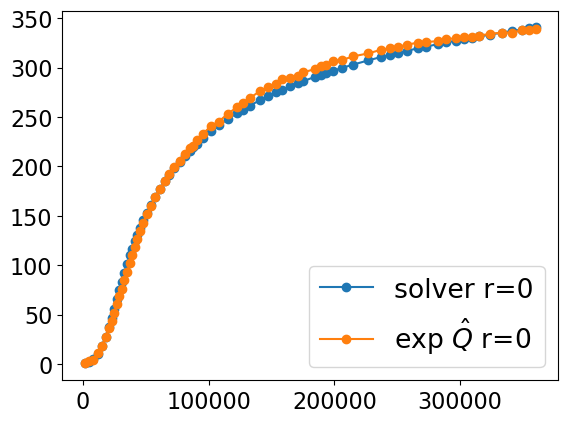

In [11]:
ratio =0
plt.plot(inp_obs['time_list'],Q_y, '-o', label = 'solver r=0')
plt.plot(inp_obs['time_list'],hydration_data[ratio][20]['heat'], '-o', label = 'exp $\hat{Q}$ r=0')

plt.legend()

## Defining Probabilistic model

In [83]:
class likelihood(object):
    def __init__(self,obs : list,sigma : float,solver :callable, **kwargs):
        self.obs = obs
        self._sigma = sigma
        self.solver = solver
        self.inp_obs_solver = kwargs['inp_obs']

    def logeval(self,b ) -> float:
        assert isinstance(b,np.ndarray)
        y_c = self.solver(b,self.inp_obs_solver)
        cov = np.diag((self._sigma*y_c))
        val = ss.multivariate_normal.logpdf(self.obs,y_c,self._sigma)
        #val = ss.norm.logpdf(y_c,self.obs,np.sqrt(self._ssigma))
        return val

In [78]:
lkl_tmp = likelihood(obs= np.array(hydration_data[ratio][20]['heat']),sigma=1e-02,solver=forward_model, inp_obs = inp_obs)

In [79]:
inp_latents_test  = np.array([2.916E-4, 0.0024229, 5.554, 500e3])
lkl_tmp.logeval(inp_latents_test)

[[0.0046282  0.         0.         ... 0.         0.         0.        ]
 [0.         0.02114925 0.         ... 0.         0.         0.        ]
 [0.         0.         0.04899427 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 3.38426604 0.         0.        ]
 [0.         0.         0.         ... 0.         3.39519807 0.        ]
 [0.         0.         0.         ... 0.         0.         3.40519057]]


-49973392.84415679

In [84]:
class posterior(object):
    def __init__(self, prior, likelihood):

        self._prior = prior
        self._likelihood = likelihood

    def logeval(self,b, phi):

        #return self._prior.LogEvaluate(x)[0] + self._likelihood.LogEvaluate(x),self._prior.LogEvaluate(x)[1]
        return self._prior.logeval(b,phi)[0] + self._likelihood.logeval(b)

In [16]:
pos = posterior(pr,lkl_tmp)
pos.logeval(inp_latents_test,phi)

-124999553048.04453

In [85]:
# defining target
def log_h(b,phi :list,obs_data :dict, i):
    """
    This needs to be overloaded
    Parameters
    ----------
    b :
    phi :
    obs_data :
    i : Index of the observed datapair

    Returns
    -------

    """
    # defining data



    # defining the prior
    ratio = list(obs_data.keys())[i] # the ratio here
    prior_tmp = Prior_(np.array([float(ratio)]))

    # defining the likelihood
    inp_obs = {
    'T_rxn' : list(hydration_data[ratio].keys())[0], # selecting the first temp value i.e 20
    'time_list' : hydration_data[ratio][20]['time']
    }
    lkl_tmp = likelihood(obs= obs_data[ratio][20]['heat'],sigma=0.01,solver=forward_model, inp_obs = inp_obs)

    #phi = np.array([0.9,1]) # true value, should return this

    pos = posterior(prior_tmp,lkl_tmp)
    return pos.logeval(b,phi)

In [86]:
# testing the target
#phi_mean = np.hstack((np.zeros((4,1)),inp_latents_test.reshape(-1,1)))
b_opt  = np.load('./Results/b_opt_deterministic12_09_2022_14:22.npy')
phi_mean = np.hstack((np.zeros((4,1)),b_opt[0,:].reshape(-1,1)))
phi_sd = np.ones(4)
phi_test = [phi_mean,phi_sd]
log_h(b_opt[0,:],phi = phi_test,obs_data=hydration_data,i=1)

-26009.042290705147

In [87]:
# sampling to check
rw = random_walk_metropolis(target_logprob=log_h)

In [88]:
x_init = b_opt[0,:]

In [100]:
b_samples = rw.run(N=600,stepsize=0.005*x_init,x0=np.random.normal(1,0.2,4)*x_init,phi = phi_test, obs_data = hydration_data,i=0)

100%|███████████████████████████████████████████████████████████████████████████████| 600/600 [00:56<00:00, 10.58it/s]

Acceptance ratio: 0.06333333333333334


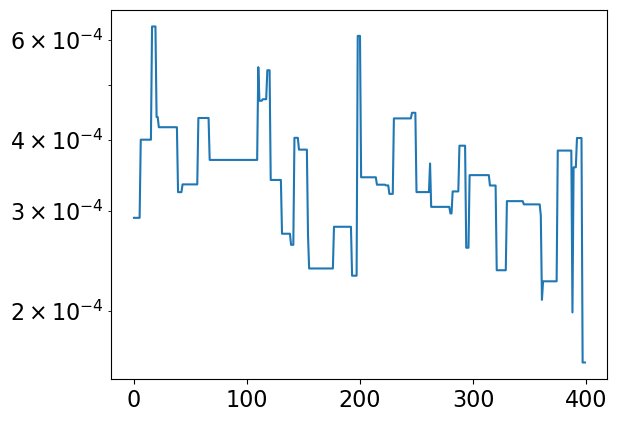

In [99]:
plt.semilogy(b_samples[:,0])

In [ ]:
def E_step(x_init, obs_data, phi, samples = 20000):
    """

    Parameters
    ----------
    x_init : [2,N]
    obs_data :
    phi :

    Returns
    -------

    """
    dim = len(obs_data['y_hat'][0])
    q_b = []
    rw = random_walk_metropolis(log_h,phi=phi)
    for i in range(dim):
        q_b_i = rw.run(samples,0.01,x0=x_init[:,i],obs_data=data,i=i)
        q_b.append(q_b_i)
    return q_b

## misc

### Performing deter opt to find the starting phi

In [133]:
for i, v in enumerate(hydration_data):
    print (i,v)

0 0
1 0.2
2 0.5
3 0.8
4 1


In [ ]:
def summation_posterior(phi, hydration_data :dict):
    assert phi.ndim == 1

    # prescibing values
    sigma_prior = 1
    sigma_lkl = 1
    for i,ratio in enumerate(hydration_data):
        pr = Prior_(x = ratio,sigma=sigma_prior)
        # solver input
        inp_obs = {
        'T_rxn' : list(hydration_data[ratio].keys())[0], # selecting the first temp value i.e 20
        'time_list' : hydration_data[ratio][20]['time']
        }
        lkl_tmp = likelihood(obs= hydration_data[ratio][20]['heat'],sigma=sigma_lkl,solver=forward_model, inp_obs = inp_obs)
        pos = posterior(prior=pr, likelihood=lkl_tmp)

    return logeval # this retruns sum of all the log values



In [ ]:
from scipy.optimize import minimize
res  = minimize(summation_posterior, phi_init = np.random.rand(8) ,args=hydration_data, method='Nelder-Mead')

In [188]:
def sum_of_squares(params, hydration_data:dict):

    # solve for all 5 data points
    Q_pred = []
    Q_exp = []
    for i,r in enumerate(hydration_data):
        # linear relation between b and phis
        b = params[0:4]*r + params[4:8]
        #b =params
        inp_obs = {
        'T_rxn' : list(hydration_data[r].keys())[0], # selecting the first temp value i.e 20
        'time_list' : hydration_data[r][20]['time']
        }
        tmp = forward_model(inp_latents=b, inp_obs=inp_obs)
        Q_pred.append(tmp)
        Q_exp.append(hydration_data[r][20]['heat'])
    Q_pred = np.stack(Q_pred)
    Q_exp = np.stack(Q_exp)
    # normalisation
    Q_pred = (Q_pred- np.mean(Q_pred))/(np.std(Q_pred) + 1e-07)
    Q_exp = (Q_exp- np.mean(Q_exp))/(np.std(Q_exp) + 1e-07)
    assert Q_exp.shape == Q_pred.shape
    obj = np.sqrt(((Q_pred - Q_exp) ** 2).sum())
    obj = np.sqrt(np.mean((Q_pred - Q_exp) ** 2)) # RMS
    print(obj)
    return obj

In [78]:
def opt_hydration(params, hydration_data:dict, ratio_c1_c2 :int):

    # solve for all 5 data points
    Q_pred = []
    Q_exp = []
    b =params
    inp_obs = {
    'T_rxn' : list(hydration_data[ratio_c1_c2].keys())[0], # selecting the first temp value i.e 20
    'time_list' : hydration_data[ratio_c1_c2][20]['time']
    }
    Q_pred = forward_model(inp_latents=b, inp_obs=inp_obs)
    Q_exp = hydration_data[ratio_c1_c2][20]['heat']
    # normalisation
    #Q_pred = (Q_pred- np.mean(Q_pred))/(np.std(Q_pred) + 1e-07)
    #Q_exp = (Q_exp- np.mean(Q_exp))/(np.std(Q_exp) + 1e-07)
    #assert Q_exp.shape == Q_pred.shape
    obj = np.sqrt(np.mean((Q_pred - Q_exp) ** 2)) # RMS
    print(obj)
    return obj

In [185]:
sum_of_squares(params=np.random.rand(8), hydration_data=hydration_data)

0.9999522231339304


0.9999522231339304

In [216]:
x_init = np.random.normal(0.5,1,4)*inp_latents_test
print(x_init)

[6.51005632e-04 1.41078751e-03 2.53195531e-01 1.67623831e+05]


In [80]:
from scipy.optimize import minimize
res  = minimize(opt_hydration, x0 = x_init ,args=(hydration_data,1), method='Nelder-Mead', options = {'maxiter': 200} )

51.8497517711377
56.254153485129095
52.17122247977241
43.75970484659042
64.53571461413935
38.21210811003562
27.20836556182127
30.819132579833276
25.602016394255834
18.08436661311652
18.242577728257285
24.655788049193358
30.94660702452417
22.007159611431042
24.745510679254593
19.65602300859834
24.990336838912725
19.52117520304837
27.141932428077027
18.187787700879383
20.67655454452216
18.182080161871987
19.13362213012391
18.012502215691086
18.22779199620859
17.797479459878332
17.37284209884422
17.585166533660082
20.55779761171629
17.49118676383495
17.23114611498695
17.343543024459457
17.471023717840747
18.748334456018497
17.336356565105326
17.049330133578042
16.825790714943906
17.434847018406874
17.230354099721303
16.936795164950812
16.78500264684108
16.619590050062076
16.492475373541428
16.172056469473276
16.004137002601777
15.528092019153517
15.777245773714135
15.054222469608039
14.232475147413933
13.91935305595865
12.457446922519942
14.100737674842039
12.159703586260225
10.5057814527

In [81]:
b_opt = []
x_init = inp_latents
for i,v in enumerate(hydration_data):
    res = minimize(opt_hydration, x0 = x_init ,args=(hydration_data,v), method='Nelder-Mead', options = {'maxiter': 300} )
    x_init = res.x
    b_opt.append(res.x)
b_opt = np.stack(b_opt)
np.save('./Results/b_opt_deterministic' + date + '.npy',b_opt)





5.322332243062649
6.277614792958742
5.457380835239635
12.068102930398194
9.834564072431863
14.744720385966199
6.977885183203168
15.153901842096491
5.5408291804641525
6.742652395284062
5.36365182272377
3.9570982384306634
5.124053838206665
7.21529437479868
4.506127436277522
4.3628436034019265
4.63841289072022
4.22005142761549
6.3927746721117975
3.774222232564618
3.716375137222347
4.800574547094593
4.65141827181226
3.7594883968343242
4.753421048984043
3.6784037455240246
4.022340035445208
3.651069363146598
3.8624785085151183
3.5997694184709372
3.896834070286334
3.592656750661961
3.9997171522698856
3.5664533518529966
3.7608210178861357
3.5804257697220665
3.649669963237145
3.5786543825870805
3.682030260225802
3.560111748484615
3.5832552558366366
3.5608113159642825
3.5611023834937647
3.6168861004897805
3.554690667661046
3.5601442479251015
3.600627673737157
3.5501584023418227
3.5574640522559124
3.5427842922408543
3.541347021975156
3.549391122111719
3.594631659277047
3.5445525733347596
3.542519

In [82]:
b_opt

array([[2.21665841e-04, 6.28614865e-03, 3.57562838e+00, 4.18829007e+05],
       [2.18171477e-04, 6.29106040e-03, 3.57579086e+00, 4.17159959e+05],
       [2.01482822e-04, 6.31606345e-03, 3.57638414e+00, 4.08389093e+05],
       [1.76423324e-04, 6.35323265e-03, 3.57731950e+00, 3.92090214e+05],
       [1.58256247e-04, 6.37990477e-03, 3.57803010e+00, 3.77036148e+05]])

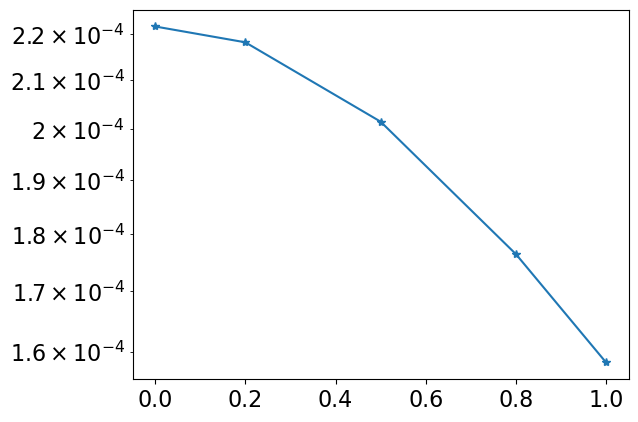

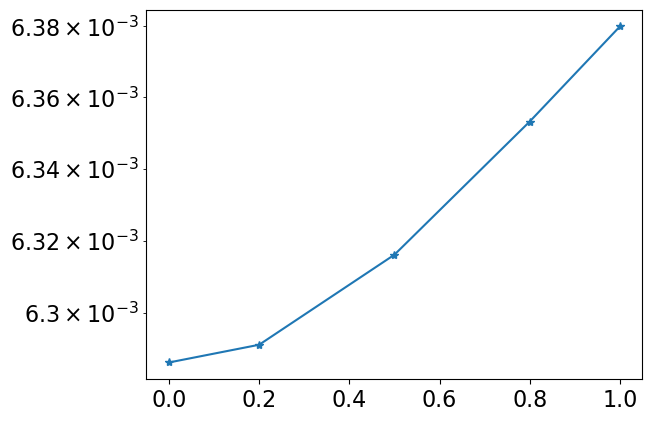

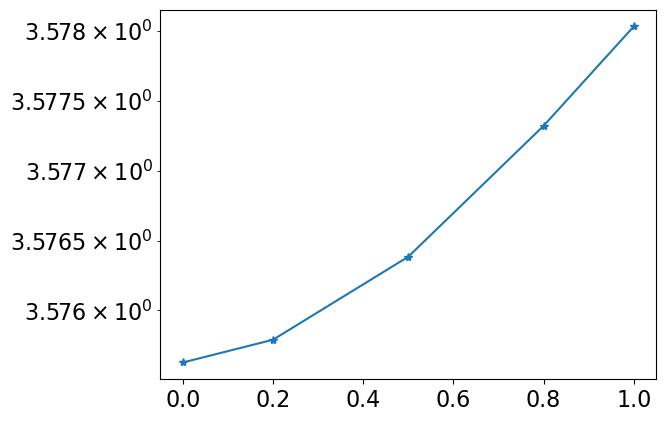

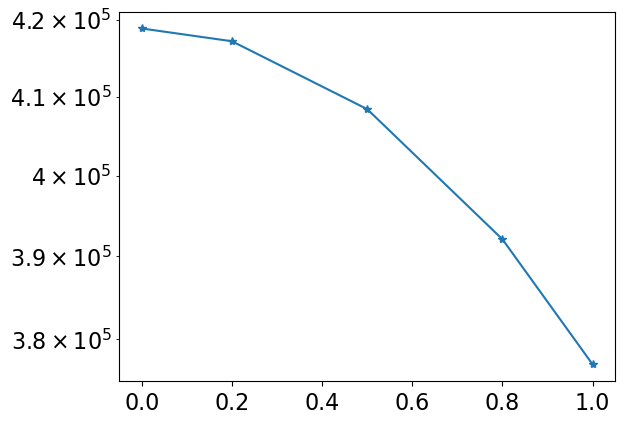

In [83]:
for i in range(b_opt.shape[1]):
    plt.figure()
    plt.semilogy(hydration_data.keys(),b_opt[:,i], '-*')

In [227]:
print(res)
print(inp_latents_test)


 final_simplex: (array([[1.56204645e-04, 1.79977617e-02, 2.65758379e+00, 3.94788748e+05],
       [1.61015035e-04, 1.60616895e-02, 2.62978200e+00, 3.91274731e+05],
       [1.50089240e-04, 2.08748814e-02, 2.57320663e+00, 3.93558414e+05],
       [1.52303671e-04, 1.99692529e-02, 2.56421022e+00, 3.91648464e+05],
       [1.52081526e-04, 1.92507201e-02, 2.54164147e+00, 3.91939936e+05]]), array([2.97102689, 3.11218479, 3.22455617, 3.22500638, 3.27644326]))
           fun: 2.9710268863701916
       message: 'Maximum number of iterations has been exceeded.'
          nfev: 335
           nit: 200
        status: 2
       success: False
             x: array([1.56204645e-04, 1.79977617e-02, 2.65758379e+00, 3.94788748e+05])
[2.9160e-04 2.4229e-03 5.5540e+00 5.0000e+05]


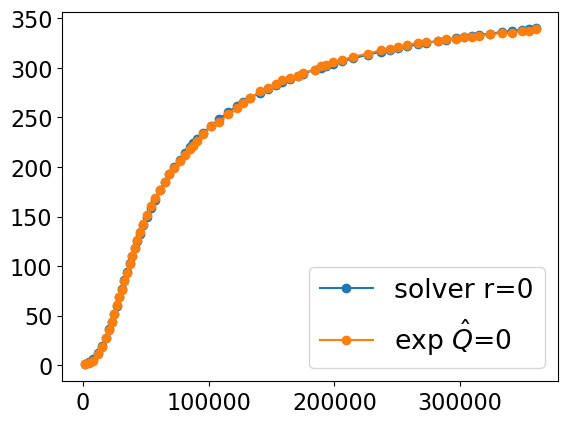

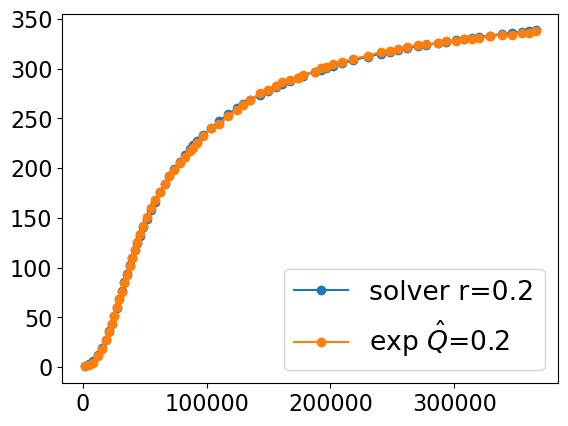

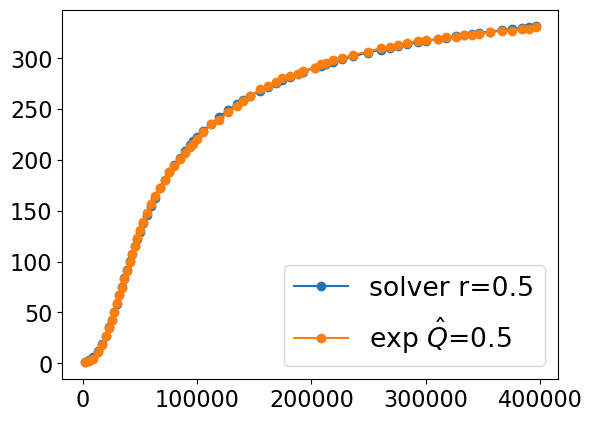

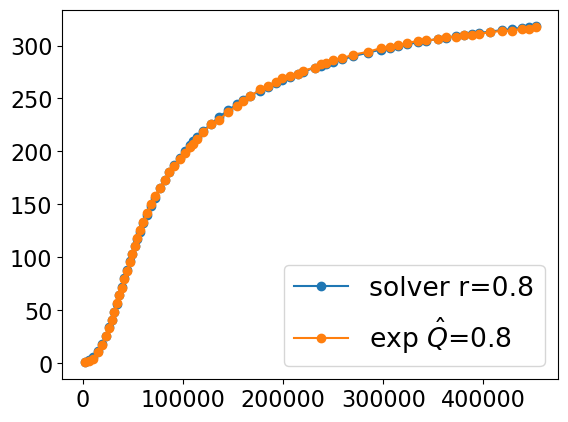

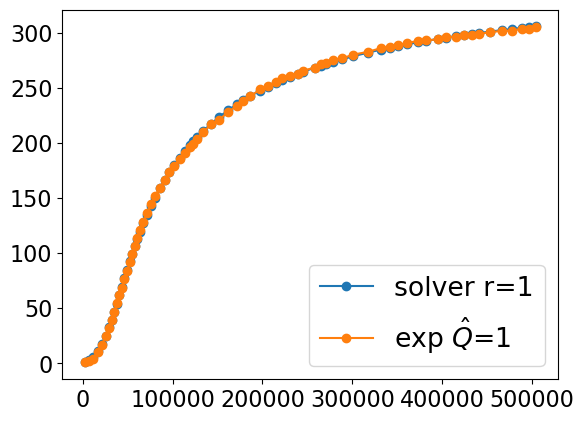

In [275]:

for i,v in enumerate(hydration_data):
    inp_obs = {
        'T_rxn': list(hydration_data[v].keys())[0],  # selecting the first temp value i.e 20
        'time_list': hydration_data[v][20]['time']
    }

    inp_latents = b_opt[i,:]
    Q_y = forward_model(inp_latents=inp_latents, inp_obs=inp_obs)

    plt.figure()
    plt.plot(inp_obs['time_list'], Q_y, '-o', label='solver r=' + str(v))
    plt.plot(inp_obs['time_list'], hydration_data[v][20]['heat'], '-o', label='exp $\hat{Q}$=' + str(v))

    plt.legend()

In [ ]:
# finding a linear relation

In [277]:
def chk_1(a,b):
    print(a,b)


In [278]:
def chk_2(**kwargs):
    chk_1(**kwargs)

In [ ]:
chk_2(a=2, b=3)